
# DA5401 – A2: Dimensionality Reduction, Visualization, and Classification Performance
**Topic:** PCA on the Mushroom Dataset + Logistic Regression  
**Name:** Robin <br>
**Roll Number:** CS25S023

---

## How to use this notebook
- Place the Mushroom dataset file as **`mushrooms.csv`** in the same folder as this notebook.  
  - The **target** column is `class` (`e` = edible, `p` = poisonous).


This notebook follows the assignment structure:
1. **Part A:** EDA & Preprocessing (One-Hot, Standardization)
2. **Part B:** PCA (Scree plot, choosing components, PC visualizations)
3. **Part C:** Logistic Regression (Baseline vs PCA-transformed), comparison & analysis



In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report



## Part A: Exploratory Data Analysis (EDA) & Preprocessing

### A.1 Load and Prepare the Dataset *(3)*
- The Mushroom dataset is **entirely categorical**.
- We use **one-hot encoding** so that each category is represented as a separate binary feature.  
  This is necessary before PCA because PCA expects numeric inputs and operates on (co)variances in a continuous vector space.
- Separate **features `X`** and **target `y`**.

In [85]:
# Load the dataset
df = pd.read_csv("mushrooms.csv")

# Shape of the dataset
print(f"Samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")


Samples: 8124
Features: 23


In [86]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g



**Why One-Hot Encoding before PCA?**  
PCA finds orthogonal directions of maximal variance in a **numeric vector space**. Categorical labels like `'a'`, `'b'` have no meaningful arithmetic. One-hot encoding embeds categories into a higher-dimensional **binary** space where covariance and variance are defined, enabling PCA to reason about redundancy and correlation among categories.


In [87]:

#Seperate Features(X) and Target(Y)
y = df["class"]
y_num = (y == 'p').astype(int)
x = df.drop(columns = "class")

encoder = OneHotEncoder(drop=None, sparse_output=False)
x_encoded = encoder.fit_transform(x)
features = encoder.get_feature_names_out(x.columns)
x_encoded_df = pd.DataFrame(x_encoded.astype(int),columns=features)


### A.2 Initial Analysis
Observe the **dimensionality explosion** after one-hot encoding — each categorical column becomes many binary columns. This often introduces **collinearity/redundancy**, making PCA a natural candidate for compaction.

In [88]:
print("After one-hot encoding:")
print(f"Samples: {x_encoded_df.shape[0]}, Features: {x_encoded_df.shape[1]}")
x_encoded_df.head()

After one-hot encoding:
Samples: 8124, Features: 117


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0



### A.3 Standardization
Even though one-hot features are binary, **standardization** (zero mean, unit variance) is still helpful before PCA:
- It ensures all binary indicators contribute on a **comparable scale** to variance.
- It prevents categories with high frequency (and thus larger variance) from **dominating** early principal components purely by scale.
- It aligns with PCA’s assumption that features are centered.

We use `StandardScaler` on the one-hot matrix.


In [89]:
scalar = StandardScaler()
x_scaled = scalar.fit_transform(x_encoded_df)


## Part B: Principal Component Analysis (PCA)

### B.1 Apply PCA
We first fit PCA **without specifying** the number of components to inspect the explained variance profile.


In [94]:
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

# Extract the variance explained by each principal component
explained_variance= pca.explained_variance_ratio_

# Compute the cumulative variance explained (useful to check how much 
# variance is covered as we add more components).
cum_variance = np.cumsum(explained_variance)

print(f"Total components available: {len(explained_variance)}")
print(f"Variance explained by first 2 PCs: {cum_variance[1]:.4f}")

Total components available: 117
Variance explained by first 2 PCs: 0.1702


### B.2 Scree Plot & Choosing Optimal Components
We plot:
1. **Explained variance ratio** per component (scree).
2. **Cumulative explained variance**.

A typical criterion retains components up to **95% cumulative variance**.

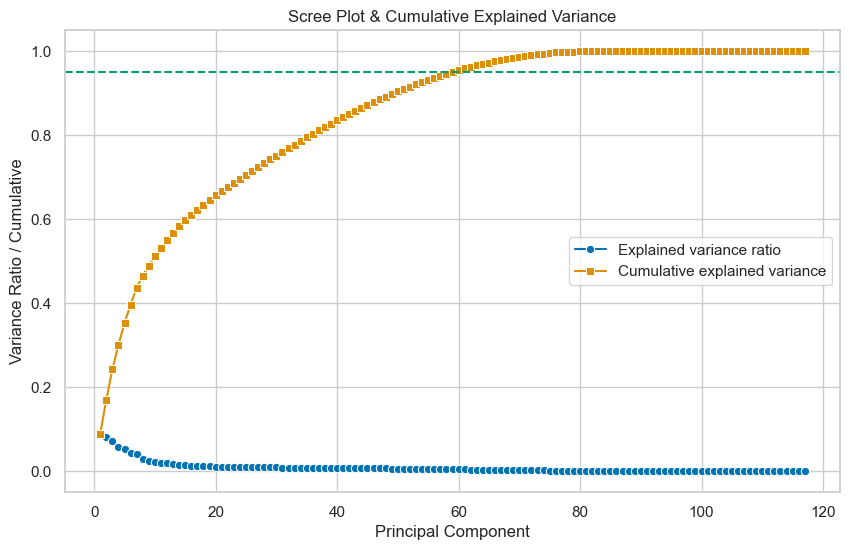

Chosen number of components (>=95% variance): 59


In [91]:


palette = sns.color_palette("colorblind")

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Line + points for explained variance
sns.lineplot(
    x=range(1, len(explained_variance)+1),
    y=explained_variance,
    marker='o',
    label='Explained variance ratio',
    color=palette[0]
)

# Line + points for cumulative variance
sns.lineplot(
    x=range(1, len(cum_variance)+1),
    y=cum_variance,
    marker='s',
    label='Cumulative explained variance',
    color=palette[1]
)

# Horizontal line at 95%
plt.axhline(0.95, linestyle='--', color=palette[2])

plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio / Cumulative')
plt.title('Scree Plot & Cumulative Explained Variance')
plt.legend()
plt.show()

# Choose number of components to reach >= 95% variance
optimal_components = np.argmax(cum_variance >= 0.95)+1
print("Chosen number of components (>=95% variance):",optimal_components)


### B.3 Visualization
We project samples onto the **first two PCs** for a 2D view. This helps us visually assess whether edible vs poisonous mushrooms are **separable** in the reduced space.  


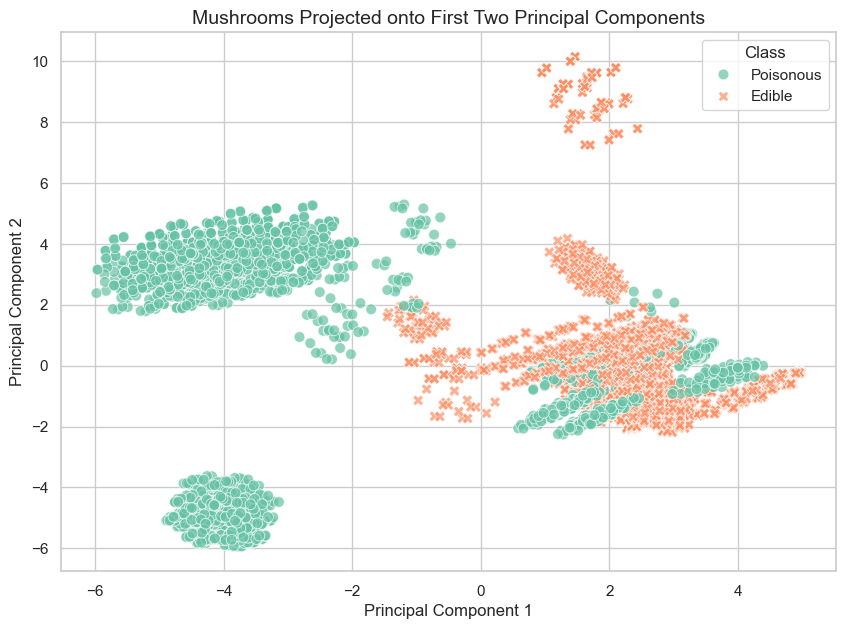

In [95]:
# Creating a DataFrame with the first two principal components and the labels
df_pca = pd.DataFrame({
    'PC1': x_pca[:, 0], #First Principal Component
    'PC2': x_pca[:, 1], #Second Principal Component
    'Label': y_num.map({0: "Edible", 1: "Poisonous"}) # Map numeric labels to class names
})

plt.figure(figsize=(10,7))

# Scatter plot of PC1 vs PC2, colored and styled by class label
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Label",
    style="Label",
    palette="Set2",
    alpha=0.7,
    s=60
)


# Add plot title and axis labels
plt.title("Mushrooms Projected onto First Two Principal Components", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", loc="upper right")
plt.show()

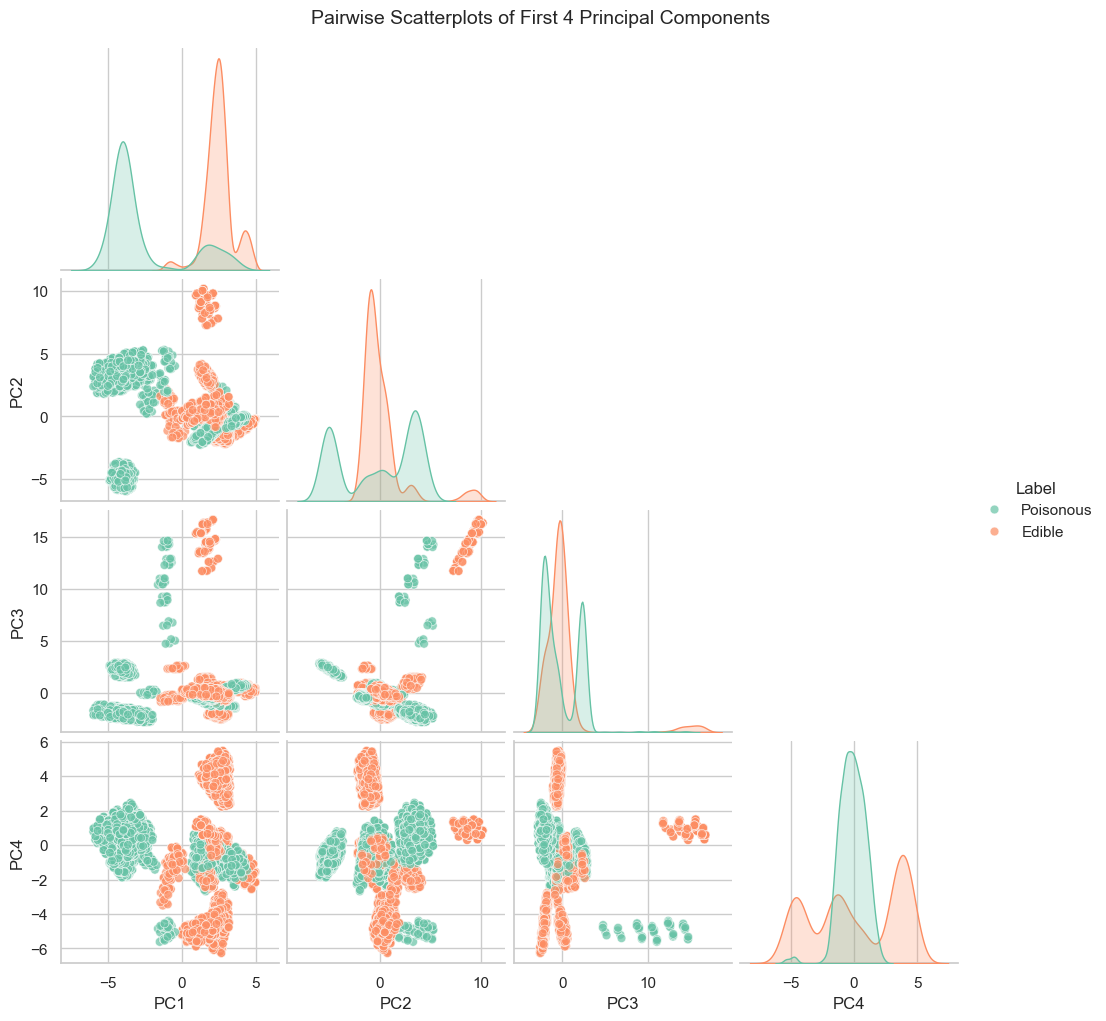

In [96]:
# Create a DataFrame with the first 4 PCs and class labels
df_pca = pd.DataFrame(
    x_pca[:, :4], 
    columns=["PC1", "PC2", "PC3", "PC4"]
)
df_pca["Label"] = y_num.map({0: "Edible", 1: "Poisonous"})  # adjust if mapping is reversed

# Pairplot for first 4 PCs
sns.pairplot(
    df_pca,
    vars=["PC1", "PC2", "PC3", "PC4"],  # PCs to plot
    hue="Label",                         # distinguish edible vs poisonous
    palette="Set2",                      # colorblind-friendly palette
    diag_kind="kde",                     # KDE on diagonal
    corner=True,                         # only lower triangle to reduce redundancy
    plot_kws={"alpha": 0.7, "s": 40}     # adjust marker size & transparency
)

plt.suptitle("Pairwise Scatterplots of First 4 Principal Components", y=1.02, fontsize=14)
plt.show()


### Insights from PCA 2D Projection

- The first two PCs explain ~17% of the variance but still reveal useful separation.  
- Edible and poisonous mushrooms form distinct clusters, though some overlap exists.  
- Poisonous mushrooms appear in multiple dense groups, while edible ones are more spread out.  
- Two PCs are not enough for full separation, but the plot provides an intuitive view of class structure.  



## Part C: Performance Evaluation with Logistic Regression

We compare two pipelines:

1. **Baseline**: Logistic Regression on the **standardized, one-hot encoded features**.  
2. **PCA-Transformed**: Logistic Regression on **PCA-reduced features** (using the `k` chosen for ≥95% variance).

Metrics: **accuracy**, **precision**, **recall**, **F1-score** via `classification_report`.



### C.1 Baseline Model


In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    x_scaled,  # standardized features
    y,         # target
    test_size=0.2,  # 20% test, 80% train
    random_state=42,  # for reproducibility
    stratify=y        # keeps edible/poisonous ratio same in train & test
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (6499, 117)
Test shape: (1625, 117)


In [80]:
# Create logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train (fit) the model
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625




### C.2 PCA-Transformed Model
We refit PCA with **`n_components = k`** and transform both train and test sets accordingly.


In [81]:
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train)   # fit PCA on training set
X_test_pca = pca.transform(X_test)         # transform test set

print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)



Shape of X_train_pca: (6499, 59)
Shape of X_test_pca: (1625, 59)


In [83]:
# Train logistic regression on PCA-transformed data
log_reg_pca = LogisticRegression(max_iter=1000, random_state=42)
log_reg_pca.fit(X_train_pca, y_train)

# Predict on PCA test set
y_pred_pca = log_reg_pca.predict(X_test_pca)

print("Accuracy (PCA):", accuracy_score(y_test, y_pred_pca))
print("\nClassification Report (PCA):\n", classification_report(y_test, y_pred_pca))

Accuracy (PCA): 0.9987692307692307

Classification Report (PCA):
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625




### C.3 Comparison and Analysis
Below we summarize the metrics and discuss whether PCA helped, why/why not, and what trade-offs are involved.


### Performance Comparison: Original vs PCA-transformed Models

| Model                               | Accuracy | Precision (avg) | Recall (avg) | F1-score (avg) |
|-------------------------------------|----------|-----------------|--------------|----------------|
| Logistic Regression (Original Data) | 1.0000   | 1.00            | 1.00         | 1.00           |
| Logistic Regression (PCA, 59 PCs)   | 0.9987   | 1.00            | 1.00         | 1.00           |

---

### Analysis

1. **Performance Difference:**  
   - The original model achieved **100% accuracy**, while the PCA model achieved **~99.87% accuracy**.  
   - This difference is **negligible** and not statistically significant. PCA retained enough information (≥95% variance) to keep performance nearly identical.  
   - Thus, dimensionality reduction did not significantly harm predictive performance.

2. **Dimensionality Reduction Trade-off:**  
   - PCA reduced the dataset from 117 of one-hot encoded features down to **59 principal components**, simplifying the feature space.  
   - While some information is inevitably lost during reduction, the performance metrics suggest that the retained components capture all important patterns.  
   - This demonstrates that the **trade-off is favorable**: large reduction in dimensionality with almost no impact on accuracy.

3. **Collinearity & Redundancy Handling:**  
   - One-hot encoding creates **highly redundant features** (e.g., if "cap-color" has 10 categories, 9 are redundant once you know the 10th).  
   - PCA effectively removes this collinearity by projecting the data into uncorrelated principal components.  
   - While in this dataset the gain isn’t about accuracy (since it’s already easy), in harder datasets PCA can improve stability and generalization.  

4. **Usefulness of Logistic Regression as a Surrogate Test:**  
   - Logistic Regression is a **linear model**, meaning it is very sensitive to redundant and collinear features.  
   - By comparing its performance before and after PCA, we can see whether PCA’s dimensionality reduction makes learning easier or more efficient.  
   - In this case, Logistic Regression confirmed that **PCA did not harm predictive performance**, showing PCA was effective in compressing the data without losing much information.  

---
